### Boosting for classifying individuals

In [11]:
library(tidyverse)
#install.packages("gbm")
library(gbm)
library(caret)
library(pROC)
library(splitTools)

### Real data

In [2]:
#data <- readRDS("../data/ATAC_predictions_train_XX_predict_XX/ATAC_pred_lasso_normalized_trimmed_formatted_standardized.rds")
#data <- data[1:1000, 1:50]
data <- readRDS(snakemake@input[["input_predictions"]])
head(data)

,sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr10_434,chr10_435,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442
V1,PGDX16568P,0.7621097,-0.8032188,0.6402487,-0.8688929,-0.4792134,-0.5096581,0.02594817,0.7295906,0.7738027,...,-0.6637417,-0.4123129,-1.1615665,-0.7530151,-0.9655041,-0.6951299,-0.5849518,0.7218669,-0.6730993,-0.8215668
V2,PGDX16569P,0.7057109,-0.8227554,0.7868749,-1.0407754,-0.9284673,-0.4139074,-0.16594560,0.7765621,0.5761691,...,-0.7122704,-0.4270698,-0.3406501,-0.8268550,-0.9877872,-0.8538511,-1.1491737,0.1395384,-0.6311258,-0.9752787
V3,PGDX16570P,0.4891340,-1.1448217,0.9478602,-1.0930696,-0.5115270,-0.7552269,-0.48824613,0.9537215,0.6624865,...,-0.6920604,-1.3985908,-0.9616793,-0.6763254,-0.8348644,-0.5606900,-0.7004571,0.9614381,-0.8445958,-0.7454436
V4,PGDX16571P,0.6882727,-0.8585679,0.6248431,-0.8310281,-0.5335804,-0.5125528,-0.34185944,0.9281618,0.4768828,...,-0.9184516,-1.0162209,-0.9296043,-1.0009798,-1.0099187,-0.9768317,-1.4301907,0.8150140,-0.8930430,-1.1244985
V5,PGDX16579P,0.5801896,-1.1674832,0.7883376,-1.0498406,-1.2475692,-0.7345196,-0.18778863,0.2546093,0.2920616,...,-0.8763019,-1.2585489,-0.8406589,-0.5846482,-1.0741005,-0.7867522,-1.1933136,0.5399897,-0.8456214,-1.3406708
V6,PGDX16580P,0.6831409,-0.8712906,0.7199476,-1.1853489,-0.8520159,-0.6829992,-0.35499242,0.8598551,0.3870744,...,-0.7874238,-0.5749897,-1.2492474,-0.2384666,-1.0734544,-0.9928378,-0.9864058,0.5544682,-1.0128443,-1.4496165


In [3]:
sample_types <- read.table(snakemake@input[["input_sample_types"]], header = F, sep = " ")
#sample_types <- read.table("../data/sample_types.txt", header = F, sep = " ")

colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [4]:
dim(data)
dim(sample_types)

[1] 1000   50

[1] 473   2

In [5]:
data <- merge(data, sample_types, by="sample")
head(data)
#data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr10_435,chr10_436,chr10_437,chr10_438,chr10_439,chr10_440,chr10_44,chr10_441,chr10_442,sample_type
PGDX10344P1,0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,...,-1.1485407,-0.4864108,0.09150152,-0.9269166,-1.3687697,-0.589546851,0.2530280,-0.9940730,-0.9518060,Gastric_cancer
PGDX10346P1,1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,...,-0.8182519,-1.2917102,-0.07914236,-1.1303181,-0.2634335,-0.082767947,0.5820590,-0.9165787,-0.9421538,Gastric_cancer
PGDX10349P1,0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,...,-0.7696023,-1.3794746,-0.79508250,-1.0769380,-1.0864319,-1.150800935,-0.9084366,-0.6919263,-0.8202496,Gastric_cancer
PGDX10351P1,1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,...,-1.0532970,-1.2672886,-0.52339685,-0.3657023,-1.2729553,-0.002047381,0.8472109,-0.7561207,-1.2037592,Gastric_cancer
PGDX10566P,0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,...,-0.7958969,-0.6793568,-0.15463406,-0.9305081,-0.8134699,-1.473896712,0.3574143,-1.3703899,-0.5677506,Ovarian_Cancer
PGDX10567P,0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,...,-1.3182514,-0.4868398,-0.66538939,-0.6901939,-1.3433134,-1.113651264,0.9034547,-0.4339943,-0.1838264,Ovarian_Cancer


In [6]:
data <- data %>% dplyr::select(-sample)

In [7]:
data %>% group_by(sample_type) %>% summarize(n = n())
data <-subset(data, sample_type != "Duodenal_Cancer")
data$sample_type <- as.factor(data$sample_type)
data <- data %>% droplevels("Duodenal_Cancer")

sample_type,n
Bile_Duct_Cancer,25
Breast_Cancer,54
Colorectal_Cancer,26
Duodenal_Cancer,1
Gastric_cancer,27
Healthy,194
Lung_Cancer,35
Ovarian_Cancer,28
Pancreatic_Cancer,34


In [8]:
data$sample_type <- as.factor(data$sample_type)

In [9]:
levels(data$sample_type)

[1] "Bile_Duct_Cancer"  "Breast_Cancer"     "Colorectal_Cancer"
[4] "Gastric_cancer"    "Healthy"           "Lung_Cancer"      
[7] "Ovarian_Cancer"    "Pancreatic_Cancer"

In [33]:
cross_validation <- function(dataset, k_inner_cv, k_outer_cv){

    y_all <- dataset$sample_type
    classes <- unique(y_all)
    return_tibble <- tibble(observed = rep(y_all, k_outer_cv), 
                            CV_rep = rep(1:k_outer_cv, each=nrow(dataset)))

    for(class in 1:length(unique(y_all))){
    y <- ifelse(y_all==classes[class], 1, 0)
    #message(y)
    return_vector_for_class <- c()
    
    
        for (i in 1:k_outer_cv){ # repeated Cross-validation loop

        set.seed(i)
        folds <- create_folds(y, k = k_inner_cv)
        predicted <- rep(NA, nrow(dataset))
  

            for (fold in folds){
                testdata  <- dataset[-fold,]
                testdata  <- testdata %>% dplyr::select(-sample_type)
                traindata <- dataset[fold,]
                
                traindata$sample_type <- ifelse(traindata$sample_type == classes[class], 1, 0)
                traindata$sample_type <- as.factor(traindata$sample_type)
                trainlabels <- traindata$sample_type
                traindata <- traindata %>% dplyr::select(-sample_type)
                
                #message(head(traindata))
                
                
                ################# Nested cross validation #######################
                set.seed(0)
                seeds <- vector(mode = "list", length = 11)
                for(i in 1:10) seeds[[i]]<- sample.int(n=1000, 18)
                #for the last model
                seeds[[11]]<-sample.int(1000, 1)

                trControl_gbm <- trainControl(method = "repeatedcv", 
                                          seeds = seeds,
                                          number = 10, 
                                          repeats = 1,
                                          verboseIter = ifelse(is.null(getOption('knitr.in.progress')), TRUE, FALSE))

                gbmGrid <- expand.grid(interaction.depth = c(1, 2, 3),
                                       n.trees = seq(200, 800, 200),
                                       shrinkage = c(0.1, 0.2, 0.01),
                                       n.minobsinnode = c(10))

                fit1 <- train(x = traindata, 
                             y = trainlabels, 
                             method = "gbm",
                             distribution = "bernoulli",
                             tuneGrid = gbmGrid,
                             trControl = trControl_gbm, 
                             verbose=F)

                #################################################################

                fitControl <- trainControl()
                fit2 <- train(x = traindata, 
                             y = trainlabels,
                             method = "gbm", 
                             distribution = "bernoulli",
                             trControl = fitControl,
                             verbose = FALSE,
                             tuneGrid = data.frame(n.trees = fit1$bestTune$n.trees,
                                                   interaction.depth = fit1$bestTune$interaction.depth,
                                                   shrinkage = fit1$bestTune$shrinkage,
                                                   n.minobsinnode = fit1$bestTune$n.minobsinnode))


                tmp <- predict(fit2, newdata = testdata, type = "prob")
                tmp <- as.data.frame(tmp, row.names = NULL)
                message(head(predicted))
                message("tmp")
                message(head(tmp))
                tmp <- predict(fit2, newdata = testdata, type = "prob")[,2]
                predicted[-fold] <- tmp


            }

            return_vector_for_class <- c(return_vector_for_class, predicted)

        } # end of outer cv loop
        return_tibble <- cbind(return_tibble, tibble("{classes[class]}" := return_vector_for_class))
    
    }                
    return(return_tibble)
}

In [34]:
k_outer_cv = 10
results = cross_validation(data, k_inner_cv = 10, k_outer_cv = k_outer_cv)

+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.966573815916921, 0.961142042321772, 0.889850283857285, 0.971445699725996, 0.946173301455853, 0.896031748509561)c(0.0334261840830791, 0.038857957678228, 0.110149716142715, 0.0285543002740035, 0.0538266985441469, 0.103968251490439)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

0.0334261840830791NANANANA0.038857957678228
tmp
c(0.919180472121423, 0.975404562420038, 0.91836752262457, 0.969084620169135, 0.971352469346827, 0.911248097610004)c(0.0808195278785775, 0.0245954375799615, 0.0816324773754302, 0.0309153798308648, 0.0286475306531727, 0.0887519023899964)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.986599175450593, 0.981163814166336, 0.989796931181146, 0.928609586469456, 0.921593465628004, 0.959809389005764)c(0.0134008245494075, 0.0188361858336638, 0.0102030688188544, 0.0713904135305441, 0.0784065343719957, 0.0401906109942365)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.0134008245494075NA0.0188361858336638NA0.0102030688188544
tmp
c(0.973259065557346, 0.97754988027761, 0.97236545015787, 0.926144204068538, 0.962189535834473, 0.930586501174189)c(0.0267409344426537, 0.02245011972239, 0.0276345498421301, 0.0738557959314617, 0.0378104641655269, 0.0694134988258115)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.984921237934196, 0.991480786698542, 0.999338121765582, 0.993594740361787, 0.979326775118286, 0.994835298066386)c(0.0150787620658039, 0.00851921330145755, 0.000661878234418434, 0.00640525963821348, 0.0206732248817143, 0.00516470193361429)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.01507876206580390.00851921330145755NA0.0006618782344184340.00640525963821348
tmp
c(0.949639583956004, 0.970784736288477, 0.941182754929999, 0.965986346499616, 0.846716007027615, 0.954323863757799)c(0.0503604160439957, 0.0292152637115233, 0.0588172450700014, 0.0340136535003837, 0.153283992972385, 0.0456761362422007)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.962772121752259, 0.945789563948576, 0.884808022719965, 0.950938288405449, 0.924816084966265, 0.971079760041677)c(0.0372278782477409, 0.0542104360514239, 0.115191977280035, 0.049061711594551, 0.0751839150337351, 0.0289202399583235)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.0372278782477409NANANANA
tmp
c(0.921272329485473, 0.939013761448735, 0.917640261937588, 0.965701784338537, 0.948504975220022, 0.956555510537932)c(0.0787276705145271, 0.0609862385512652, 0.0823597380624118, 0.0342982156614633, 0.0514950247799781, 0.0434444894620681)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.959479529386992, 0.949812705059116, 0.947772069814936, 0.946154809091701, 0.949131444482021, 0.907044429363208)c(0.0405204706130081, 0.0501872949408841, 0.0522279301850637, 0.0538451909082992, 0.0508685555179788, 0.0929555706367919)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.04052047061300810.0501872949408841NANA0.0522279301850637
tmp
c(0.951973334226067, 0.952472279413545, 0.966337958719438, 0.920581482065444, 0.665523396373945, 0.945874632695477)c(0.0480266657739331, 0.0475277205864555, 0.0336620412805617, 0.0794185179345557, 0.334476603626055, 0.0541253673045234)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.567731903837036, 0.945141213906542, 0.91381069648306, 0.873791694123074, 0.90516776897538, 0.961600224946653)c(0.432268096162964, 0.0548587860934582, 0.0861893035169397, 0.126208305876926, 0.0948322310246196, 0.0383997750533468)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.961097331831314, 0.974530452111669, 0.968436802756248, 0.937744587837779, 0.979291012288671, 0.950187753803347)c(0.0389026681686863, 0.0254695478883307, 0.0315631972437516, 0.0622554121622213, 0.0207089877113288, 0.0498122461966527)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.578105932160862, 0.932565286600431, 0.931909637695636, 0.965864253058961, 0.718792635427125, 0.0875195555755122)c(0.421894067839138, 0.0674347133995687, 0.0680903623043637, 0.0341357469410392, 0.281207364572875, 0.912480444424488)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

0.421894067839138NANANANA0.0674347133995687
tmp
c(0.0108629654546272, 0.997792615262915, 0.972762264396774, 0.222278801382467, 0.410900137907205, 0.99789620641975)c(0.989137034545373, 0.00220738473708537, 0.0272377356032262, 0.777721198617533, 0.589099862092795, 0.00210379358025037)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.987529768157555, 0.981930714110431, 0.884964874164112, 0.101265834196875, 0.118306340732069, 0.67497719323686)c(0.0124702318424448, 0.0180692858895694, 0.115035125835888, 0.898734165803125, 0.881693659267931, 0.32502280676314)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

0.0124702318424448NANA0.0180692858895694NANA
tmp
c(1.95174439211161e-06, 0.999101965146496, 0.996698345084471, 0.999831883019017, 0.999999927226056, 0.999988808305865)c(0.999998048255608, 0.000898034853503593, 0.00330165491552903, 0.000168116980982624, 7.27739435379959e-08, 1.11916941348822e-05)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.962836320404872, 0.911666971733674, 0.943412675440979, 0.925851636326713, 0.959427075948975, 0.969504787206887)c(0.0371636795951277, 0.0883330282663256, 0.0565873245590209, 0.0741483636732871, 0.0405729240510253, 0.0304952127931132)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.03716367959512770.0883330282663256NANA0.0565873245590209
tmp
c(0.97025555976679, 0.926118225015394, 0.98392596918842, 0.958505401934508, 0.963561455509289, 0.936459141296137)c(0.0297444402332101, 0.0738817749846064, 0.0160740308115804, 0.0414945980654922, 0.0364385444907106, 0.0635408587038628)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.964597123085268, 0.906048490834643, 0.974392857623493, 0.981968485881246, 0.967729867847824, 0.950508790722643)c(0.0354028769147318, 0.0939515091653574, 0.0256071423765071, 0.0180315141187543, 0.0322701321521757, 0.0494912092773572)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.0354028769147318NANANANA
tmp
c(0.973452457147431, 0.882144727265752, 0.886614749795797, 0.972087472334907, 0.945138988656286, 0.954134888451998)c(0.0265475428525688, 0.117855272734248, 0.113385250204203, 0.0279125276650931, 0.0548610113437141, 0.0458651115480022)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.936508466171696, 0.63690385981663, 0.950293160260584, 0.931863378497072, 0.957237331631012, 0.896197698896455)c(0.0634915338283041, 0.36309614018337, 0.0497068397394156, 0.068136621502928, 0.0427626683689878, 0.103802301103545)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.06349153382830410.36309614018337NANA0.0497068397394156
tmp
c(0.947350391304396, 0.961057922749648, 0.969406230763809, 0.907150562491999, 0.906485984468787, 0.735860000310832)c(0.0526496086956044, 0.0389420772503525, 0.0305937692361907, 0.0928494375080006, 0.0935140155312131, 0.264139999689168)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”NANANANANANA
tmp
c(0.832564814871987, 0.740485790802865, 0.939543311964438, 0.959441943378652, 0.900277620234033, 0.936323380371849)c(0.167435185128013, 0.259514209197135, 0.0604566880355625, 0.0405580566213481, 0.0997223797659667, 0.0636766196281512)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.99999337436702, 0.999788939345312, 0.740726092196882, 0.998796723661446, 0.999972576415372, 0.997865454411055)c(6.62563298026164e-06, 0.000211060654688344, 0.259273907803118, 0.00120327633855399, 2.74235846281501e-05, 0.00213454558894466)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.922419305814533, 0.90379281336844, 0.92350815580766, 0.836967622737067, 0.789924518408698, 0.882427499191191)c(0.0775806941854673, 0.0962071866315602, 0.0764918441923402, 0.163032377262933, 0.210075481591302, 0.117572500808809)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.07758069418546730.0962071866315602NANANA
tmp
c(0.802608911413943, 0.895253339659896, 0.89574984485692, 0.864132307160387, 0.932541015079536, 0.560131373946114)c(0.197391088586057, 0.104746660340104, 0.10425015514308, 0.135867692839613, 0.0674589849204641, 0.439868626053886)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.881124835637367, 0.796965415281312, 0.897476383232165, 0.912112962262042, 0.872004093735748, 0.888877665730252)c(0.118875164362633, 0.203034584718688, 0.102523616767835, 0.087887037737958, 0.127995906264252, 0.111122334269748)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.954372293419368, 0.969993036182923, 0.971943787620363, 0.974436691544316, 0.822312587130509, 0.883149374183001)c(0.0456277065806323, 0.0300069638170767, 0.0280562123796373, 0.0255633084556839, 0.177687412869491, 0.116850625816999)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.998622657946109, 0.999999866130424, 0.999999992619977, 0.999850353213964, 0.994194456428545, 0.999801572434842)c(0.00137734205389128, 1.33869576202095e-07, 7.38002325917364e-09, 0.000149646786035795, 0.00580554357145502, 0.000198427565157533)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.001377342053891281.33869576202095e-07NANA7.38002325917364e-09
tmp
c(0.9587249276962, 0.945795797843467, 0.965968312855108, 0.93302124822216, 0.901159743057383, 0.931822187498471)c(0.0412750723038001, 0.0542042021565328, 0.0340316871448917, 0.0669787517778397, 0.0988402569426169, 0.0681778125015288)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NANANANANANA
tmp
c(0.912350698274296, 0.932050105554646, 0.936421032164553, 0.953526872348261, 0.905225708634484, 0.954210116276853)c(0.0876493017257036, 0.0679498944453543, 0.0635789678354469, 0.0464731276517395, 0.0947742913655159, 0.0457898837231467)


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=1, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=2, n.minobsinnode=10, n.trees=800 
+ Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=800 
- Fold01.Rep1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.tre

NA0.0876493017257036NANANANA
tmp
c(0.948210567034048, 0.949051651764295, 0.939460544678709, 0.956772803984042, 0.967718695071975, 0.908028092461483)c(0.0517894329659516, 0.0509483482357054, 0.060539455321291, 0.0432271960159584, 0.0322813049280245, 0.0919719075385171)


In [ ]:
saveRDS(results, file = snakemake@output[["boosting_output"]])

In [35]:
head(results)

observed,CV_rep,Gastric_cancer_pred,Ovarian_Cancer_pred,Lung_Cancer_pred,Healthy_pred,Bile_Duct_Cancer_pred,Pancreatic_Cancer_pred,Breast_Cancer_pred,Colorectal_Cancer_pred
Gastric_cancer,1,0.03342618,0.0503604160,0.04802667,0.421894068,0.02974444,0.05264961,0.19739109,4.127507e-02
Gastric_cancer,1,0.08081953,0.0150787621,0.04052047,0.989137035,0.03716368,0.06349153,0.07758069,1.377342e-03
Gastric_cancer,1,0.02459544,0.0085192133,0.05018729,0.002207385,0.08833303,0.36309614,0.09620719,1.338696e-07
Gastric_cancer,1,0.08163248,0.0292152637,0.04752772,0.027237736,0.07388177,0.03894208,0.10474666,5.420420e-02
Ovarian_Cancer,1,0.03091538,0.0006618782,0.03366204,0.777721199,0.01607403,0.03059377,0.10425016,3.403169e-02
Ovarian_Cancer,1,0.03885796,0.0064052596,0.05222793,0.067434713,0.05658732,0.04970684,0.13586769,7.380023e-09


## AUC calculation with pROC package == One vs. one

In [28]:
rocs <- list()
list_names <- paste0("CV_rep_", 1:k_outer_cv)
for (i in 1:k_outer_cv){
    res_CV <- results %>% filter(CV_rep == i) %>% dplyr::select(-c(CV_rep, observed))
    roc <- multiclass.roc(response = data$sample_type, predictor = res_CV)
    rocs[[i]] <- roc
}
names(rocs) <- c(list_names)

paste0("The AUC of the first CV repetition: ", rocs[[1]]$auc)

aucs <- c()
for (i in 1:length(rocs)){
    aucs <- c(aucs, rocs[[i]]$auc) 
}

paste0("The mean AUC of all the CV repetitions: ", mean(aucs))

[1] "The AUC of the first CV repetition: 0.585049124506721"

[1] "The mean AUC of all the CV repetitions: 0.581406783835352"

## AUC calculation with functions == One vs. one (source: https://www.datascienceblog.net/post/machine-learning/performance-measures-multi-class-problems/)

In [29]:
# run only for the first CV repetition to check that we get the same number

res_CV <- data.frame(results %>% filter(CV_rep == 1) %>% dplyr::select(-c(CV_rep, observed)))
head(res_CV)

Bile_Duct_Cancer,Breast_Cancer,Colorectal_Cancer,Gastric_cancer,Healthy,Lung_Cancer,Ovarian_Cancer,Pancreatic_Cancer
0.08451596,0.12449974,0.10573239,0.09832263,0.4396225,0.03600163,0.06234826,0.04895693
0.03696332,0.07010661,0.03428572,0.06833152,0.6324460,0.04165260,0.04571403,0.07050022
0.10409599,0.06634937,0.04497620,0.03812102,0.3100308,0.04004931,0.06248392,0.33389338
0.17665811,0.06272099,0.08684732,0.13743426,0.3149044,0.08039161,0.04021411,0.10082922
0.04770583,0.13782552,0.06066183,0.08277858,0.4649827,0.05711471,0.05006588,0.09886495
0.06943789,0.16571591,0.02038594,0.04170619,0.5652152,0.04996682,0.03919751,0.04837456


In [30]:
compute.A.conditional <- function(pred.matrix, i, j, ref.outcome) {
    # computes A(i|j), the probability that a randomly 
    # chosen member of class j has a lower estimated probability (or score) 
    # of belonging to class i than a randomly chosen member of class i

    # select predictions of class members
    i.idx <- which(ref.outcome == i)
    j.idx <- which(ref.outcome == j)
    pred.i <- pred.matrix[i.idx, i] # p(G = i) assigned to class i observations
    pred.j <- pred.matrix[j.idx, i] # p(G = i) assigned to class j observations
    all.preds <- c(pred.i, pred.j)
    classes <- c(rep(i, length(pred.i)), rep(j, length(pred.j)))
    o <- order(all.preds)
    classes.o <- classes[o]
    # Si: sum of ranks from class i observations
    Si <- sum(which(classes.o == i))
    ni <- length(i.idx)
    nj <- length(j.idx)
    # calculate A(i|j)
    A <- (Si - ((ni * (ni + 1))/2)) / (ni * nj)
    return(A)
}

multiclass.auc <- function(pred.matrix, ref.outcome) {
    labels <- colnames(pred.matrix)
    A.ij.cond <- utils::combn(labels, 2, function(x, pred.matrix, ref.outcome) {x
        i <- x[1]
        j <- x[2]
        A.ij <- compute.A.conditional(pred.matrix, i, j, ref.outcome)
        A.ji <- compute.A.conditional(pred.matrix, j, i, ref.outcome)
        pair <- paste0(i, "/", j)
        return(c(A.ij, A.ji))
    }, simplify = FALSE, pred.matrix = pred.matrix, ref.outcome = ref.outcome)
    c <- length(labels)
    pairs <- unlist(lapply(combn(labels, 2, simplify = FALSE), function(x) paste(x, collapse = "/")))
    A.mean <- unlist(lapply(A.ij.cond, mean))
    names(A.mean) <- pairs
    A.ij.joint <- sum(unlist(A.mean))
    M <- 2 / (c * (c-1)) * A.ij.joint 
    attr(M, "pair_AUCs") <- A.mean
    return(M)
}                          
M <- multiclass.auc(res_CV, data$sample_type)
print(paste0("Generalized AUC is: ", round(as.numeric(M), 3)))
                           
print(attr(M, "pair_AUCs"))

[1] "Generalized AUC is: 0.585"
     Bile_Duct_Cancer/Breast_Cancer  Bile_Duct_Cancer/Colorectal_Cancer 
                          0.6037037                           0.5538462 
    Bile_Duct_Cancer/Gastric_cancer            Bile_Duct_Cancer/Healthy 
                          0.5644444                           0.6048454 
       Bile_Duct_Cancer/Lung_Cancer     Bile_Duct_Cancer/Ovarian_Cancer 
                          0.5771429                           0.5642857 
 Bile_Duct_Cancer/Pancreatic_Cancer     Breast_Cancer/Colorectal_Cancer 
                          0.4141176                           0.5936610 
       Breast_Cancer/Gastric_cancer               Breast_Cancer/Healthy 
                          0.6313443                           0.6621325 
          Breast_Cancer/Lung_Cancer        Breast_Cancer/Ovarian_Cancer 
                          0.5798942                           0.5429894 
    Breast_Cancer/Pancreatic_Cancer    Colorectal_Cancer/Gastric_cancer 
                   

In [31]:
## AUC calculation with HandTill2001 package == One vs. one (original paper of the approach: https://link.springer.com/content/pdf/10.1023/A:1010920819831.pdf)

In [32]:
if (! require("remotes")) install.packages("remotes")
remotes::install_gitlab("fvafrCU/HandTill2001")

library(HandTill2001)

# run only for the first CV repetition to check that we get the same number

paste0("The AUC of the first CV repetition: ", auc(multcap(response = data$sample_type, predicted = as.matrix(res_CV))))


Loading required package: remotes
Skipping install of 'HandTill2001' from a gitlab remote, the SHA1 (90deae92) has not changed since last install.
  Use `force = TRUE` to force installation

Attaching package: ‘HandTill2001’

The following object is masked from ‘package:pROC’:

    auc



[1] "The AUC of the first CV repetition: 0.585049124506721"

# AUC calculation with multiROC package == One vs. rest, and plotting (https://github.com/WandeRum/multiROC)

In [33]:
install.packages('multiROC')
library(multiROC)

install.packages('dummies')
library(dummies)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
dummies-1.5.6 provided by Decision Patterns



### Example of the calculations and plotting wiht the first CV repetition

In [34]:
# prep the data frame

colnames(res_CV) <- paste(colnames(res_CV), "_pred_lasso", sep = "")

true_label <- dummies::dummy(data$sample_type, sep = ".")
true_label <- data.frame(true_label)
colnames(true_label) <- gsub(".*?\\.", "", colnames(true_label))
colnames(true_label) <- paste(colnames(true_label), "_true", sep = "")
final_df <- cbind(true_label, res_CV)

head(final_df)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”

Bile_Duct_Cancer_true,Breast_Cancer_true,Colorectal_Cancer_true,Gastric_cancer_true,Healthy_true,Lung_Cancer_true,Ovarian_Cancer_true,Pancreatic_Cancer_true,Bile_Duct_Cancer_pred_lasso,Breast_Cancer_pred_lasso,Colorectal_Cancer_pred_lasso,Gastric_cancer_pred_lasso,Healthy_pred_lasso,Lung_Cancer_pred_lasso,Ovarian_Cancer_pred_lasso,Pancreatic_Cancer_pred_lasso
0,0,0,1,0,0,0,0,0.08451596,0.12449974,0.10573239,0.09832263,0.4396225,0.03600163,0.06234826,0.04895693
0,0,0,1,0,0,0,0,0.03696332,0.07010661,0.03428572,0.06833152,0.6324460,0.04165260,0.04571403,0.07050022
0,0,0,1,0,0,0,0,0.10409599,0.06634937,0.04497620,0.03812102,0.3100308,0.04004931,0.06248392,0.33389338
0,0,0,1,0,0,0,0,0.17665811,0.06272099,0.08684732,0.13743426,0.3149044,0.08039161,0.04021411,0.10082922
0,0,0,0,0,0,1,0,0.04770583,0.13782552,0.06066183,0.08277858,0.4649827,0.05711471,0.05006588,0.09886495
0,0,0,0,0,0,1,0,0.06943789,0.16571591,0.02038594,0.04170619,0.5652152,0.04996682,0.03919751,0.04837456


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

Specificity,Sensitivity,Group,AUC,Method
1.0000000,0.00,Bile_Duct_Cancer,0.5327638,lasso
0.9974874,0.00,Bile_Duct_Cancer,0.5327638,lasso
0.9974874,0.04,Bile_Duct_Cancer,0.5327638,lasso
0.9949749,0.04,Bile_Duct_Cancer,0.5327638,lasso
0.9924623,0.04,Bile_Duct_Cancer,0.5327638,lasso
0.9899497,0.04,Bile_Duct_Cancer,0.5327638,lasso


[1] 9720    5

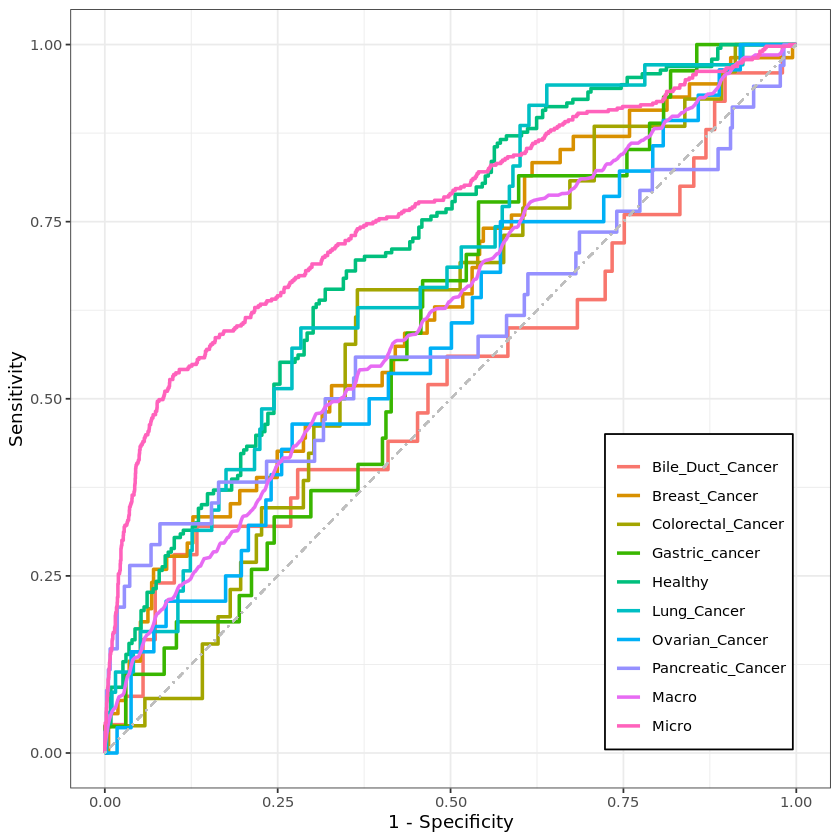

In [35]:
#perform multiroc and plot

roc_res <- multi_roc(final_df, force_diag=T)
plot_roc_df <- plot_roc_data(roc_res)
head(plot_roc_df)
dim(plot_roc_df)

ggplot(plot_roc_df, aes(x = 1-Specificity, y=Sensitivity)) +
  geom_path(aes(color = Group), size=1) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
                        colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  theme(plot.title = element_text(hjust = 0.5), 
                 legend.justification=c(1, 0), legend.position=c(.95, .05),
                 legend.title=element_blank(), 
                 legend.background = element_rect(fill=NULL, size=0.5, 
                                                           linetype="solid", colour ="black"))


In [36]:
# print AUCs
(AUCs <-roc_res$AUC %>%
  transpose() %>%
  as_tibble())

Bile_Duct_Cancer,Breast_Cancer,Colorectal_Cancer,Gastric_cancer,Healthy,Lung_Cancer,Ovarian_Cancer,Pancreatic_Cancer,macro,micro
0.5327638,0.6330924,0.5999806,0.5919379,0.7089317,0.6790133,0.5861664,0.5856646,0.6146813,0.7629898


## Run the multiROC and plotting for all the CV repetitions

In [37]:
Specificities <- NULL
Sensitivities <- NULL

for (i in 1:k_outer_cv){
    res_CV <- data.frame(results %>% filter(CV_rep == i) %>% dplyr::select(-c(CV_rep, observed)))
    
    colnames(res_CV) <- paste(colnames(res_CV), "_pred_lasso", sep = "")

    true_label <- dummies::dummy(data$sample_type, sep = ".")
    true_label <- data.frame(true_label)
    colnames(true_label) <- gsub(".*?\\.", "", colnames(true_label))
    colnames(true_label) <- paste(colnames(true_label), "_true", sep = "")
    final_df <- cbind(true_label, res_CV)

    roc_res <- multi_roc(final_df, force_diag=T)
    
    if (i == 1){
        AUCs <- as.data.frame(t(unlist(roc_res$AUC)))
    }
    else {
        AUCs <- rbind(AUCs, as.data.frame(t(unlist(roc_res$AUC))))
    }
    
    plot_roc_df <- plot_roc_data(roc_res)
    plot_roc_df <- plot_roc_df %>% dplyr::select(-Method)
    
    if (i == 1){
        Specificities <- plot_roc_df %>% dplyr::select(Specificity)
        Sensitivities <- plot_roc_df %>% dplyr::select(Sensitivity)
        Groups  <- plot_roc_df %>% dplyr::select(Group)
    }
    else {
        Specificities <- cbind(Specificities, plot_roc_df %>% dplyr::select(Specificity))
        Sensitivities <- cbind(Sensitivities, plot_roc_df %>% dplyr::select(Sensitivity))
    }
    
    #IRdisplay::display(all_plot_roc_df)

}
Specificities <- tibble(Specificities, .name_repair = "unique")
Specificities <- Specificities %>% mutate(mean = rowMeans(across()))
Sensitivities <- tibble(Sensitivities, .name_repair = "unique")
Sensitivities <- Sensitivities %>% mutate(mean = rowMeans(across()))

(AUCs <- tibble(AUCs))

all_sensitivity_specificity <- tibble(Specificity = Specificities$mean, Sensitivity = Sensitivities$mean, Group = Groups$Group)
head(all_sensitivity_specificity)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“

lasso.Bile_Duct_Cancer,lasso.Breast_Cancer,lasso.Colorectal_Cancer,lasso.Gastric_cancer,lasso.Healthy,lasso.Lung_Cancer,lasso.Ovarian_Cancer,lasso.Pancreatic_Cancer,lasso.macro,lasso.micro
0.5327638,0.6330924,0.5999806,0.5919379,0.7089317,0.6790133,0.5861664,0.5856646,0.6146813,0.7629898
0.5648241,0.6716350,0.5626817,0.6396371,0.6737721,0.6874080,0.5578662,0.4894904,0.6059090,0.7558848


Specificity,Sensitivity,Group
1.0000000,0.00,Bile_Duct_Cancer
0.9974874,0.00,Bile_Duct_Cancer
0.9962312,0.02,Bile_Duct_Cancer
0.9937186,0.02,Bile_Duct_Cancer
0.9924623,0.04,Bile_Duct_Cancer
0.9899497,0.04,Bile_Duct_Cancer


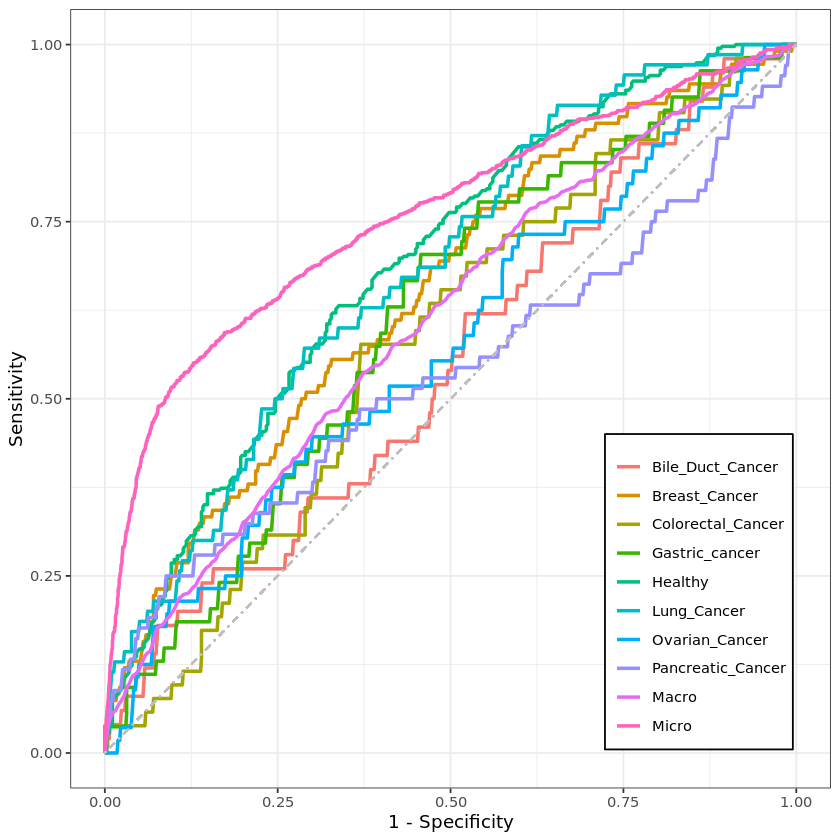

In [38]:
ggplot(all_sensitivity_specificity, aes(x = 1-Specificity, y=Sensitivity)) +
  geom_path(aes(color = Group), size=1) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
                        colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  theme(plot.title = element_text(hjust = 0.5), 
                 legend.justification=c(1, 0), legend.position=c(.95, .05),
                 legend.title=element_blank(), 
                 legend.background = element_rect(fill=NULL, size=0.5, 
                                                           linetype="solid", colour ="black"))

In [39]:
print("Mean AUC over 10 repetitions of 10-fold CV: ")
(mean_AUCs <- colMeans(AUCs[sapply(AUCs, is.numeric)]))

[1] "Mean AUC over 10 repetitions of 10-fold CV: "


lasso.Bile_Duct_Cancer     lasso.Breast_Cancer lasso.Colorectal_Cancer 
              0.5487940               0.6523637               0.5813311 
   lasso.Gastric_cancer           lasso.Healthy       lasso.Lung_Cancer 
              0.6157875               0.6913519               0.6832106 
   lasso.Ovarian_Cancer lasso.Pancreatic_Cancer             lasso.macro 
              0.5720163               0.5375775               0.6102952 
            lasso.micro 
              0.7594373

In [40]:
results01 <- tibble()

for (i in 1:k_outer_cv){
    res_CV <- results %>% filter(CV_rep == i)
    obs_rep <- res_CV %>% dplyr::select(c(CV_rep, observed))
    res_CV <- res_CV %>% dplyr::select(-c(CV_rep, observed))
    res_CV <- res_CV %>% mutate(pred01 = factor(colnames(res_CV)[apply(res_CV,1,which.max)], ordered = TRUE))
    res_CV <- cbind(res_CV, obs_rep)
    results01 <- rbind(results01, res_CV)
}

head(results01)

Bile_Duct_Cancer,Breast_Cancer,Colorectal_Cancer,Gastric_cancer,Healthy,Lung_Cancer,Ovarian_Cancer,Pancreatic_Cancer,pred01,CV_rep,observed
0.08451596,0.12449974,0.10573239,0.09832263,0.4396225,0.03600163,0.06234826,0.04895693,Healthy,1,Gastric_cancer
0.03696332,0.07010661,0.03428572,0.06833152,0.6324460,0.04165260,0.04571403,0.07050022,Healthy,1,Gastric_cancer
0.10409599,0.06634937,0.04497620,0.03812102,0.3100308,0.04004931,0.06248392,0.33389338,Pancreatic_Cancer,1,Gastric_cancer
0.17665811,0.06272099,0.08684732,0.13743426,0.3149044,0.08039161,0.04021411,0.10082922,Healthy,1,Gastric_cancer
0.04770583,0.13782552,0.06066183,0.08277858,0.4649827,0.05711471,0.05006588,0.09886495,Healthy,1,Ovarian_Cancer
0.06943789,0.16571591,0.02038594,0.04170619,0.5652152,0.04996682,0.03919751,0.04837456,Healthy,1,Ovarian_Cancer


In [41]:
error_rates <- c()
accuracies <- c()
for (i in 1:k_outer_cv){
    res_CV <- results01 %>% filter(CV_rep == i)
    error_rates <- c(error_rates, mean(as.character(res_CV$observed) != as.character(res_CV$pred01)))
    accuracies <- c(accuracies, mean(as.character(res_CV$observed) == as.character(res_CV$pred01)))
}

error_rates
accuracies

paste("Mean error rate over 10 repetitions of 10-fold CV: ", mean(error_rates), sep = "")
paste("Mean accuracy over 10 repetitions of 10-fold CV: ", mean(accuracies), sep = "")

[1] 0.5130024 0.5271868

[1] 0.4869976 0.4728132

[1] "Mean error rate over 10 repetitions of 10-fold CV: 0.520094562647754"

[1] "Mean accuracy over 10 repetitions of 10-fold CV: 0.479905437352246"